In [1]:
from transformers import AutoProcessor, AutoModelForCausalLM
from pathlib import Path
from PIL import Image
from tqdm import tqdm

import matplotlib.pyplot as plt
import matplotlib.patches as patches
import pandas as pd
import torch
import re

%matplotlib inline

In [2]:
model_id = 'microsoft/Florence-2-large'
device = torch.device("cuda")
model = AutoModelForCausalLM.from_pretrained(model_id, trust_remote_code=True, torch_dtype='auto').eval().to(device)
processor = AutoProcessor.from_pretrained(model_id, trust_remote_code=True)

c:\Users\stopc\anaconda3\envs\transformers-env\lib\site-packages\timm\models\layers\__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)


In [3]:
def apply_filters(image, bboxes, labels):
    """
    Filters detections based on criteria:
    - Focuses on "person" and "pet" classes.
    - Ensures the person is visible and occupies a reasonable portion of the image.
    - Matches keywords exactly.

    Parameters:
    - image: PIL Image object
    - bboxes: List of bounding boxes (x1, y1, x2, y2).
    - labels: List of labels corresponding to the bounding boxes.

    Returns:
    - filtered_bboxes: Filtered bounding boxes.
    - filtered_labels: Filtered labels.
    """
    filtered_bboxes = []
    filtered_labels = []
    img_width, img_height = image.size

    # Define exact keywords using regex with word boundaries
    pet_keywords = re.compile(r'\b(dog|cat)\b', re.IGNORECASE)
    person_keywords = re.compile(r'\b(person|man|woman|boy|girl|child|kid)\b', re.IGNORECASE)

    for bbox, label in zip(bboxes, labels):
        # Match exact keywords
        if pet_keywords.search(label):
            label = "pet"
        elif person_keywords.search(label):
            label = "person"
        else:
            continue  # Skip irrelevant labels

        # Compute bounding box area
        x1, y1, x2, y2 = bbox
        bbox_width = x2 - x1
        bbox_height = y2 - y1
        bbox_area = bbox_width * bbox_height
        img_area = img_width * img_height

        # Filter by bounding box size (area between 5% and 95% of image area)
        if not (0.05 * img_area <= bbox_area <= 0.95 * img_area):
            continue

        # Add filtered results
        filtered_bboxes.append([x1, y1, x2, y2])
        filtered_labels.append(label)

    return filtered_bboxes, filtered_labels

def plot_bbox(image, data):
   # Create a figure and axes
    fig, ax = plt.subplots()

    # Display the image
    ax.imshow(image)

    # Plot each bounding box
    for bbox, label in zip(data['bboxes'], data['labels']):
        # Unpack the bounding box coordinates
        x1, y1, x2, y2 = bbox
        # Create a Rectangle patch
        rect = patches.Rectangle((x1, y1), x2-x1, y2-y1, linewidth=1, edgecolor='r', facecolor='none')
        # Add the rectangle to the Axes
        ax.add_patch(rect)
        # Annotate the label
        plt.text(x1, y1, label, color='white', fontsize=8, bbox=dict(facecolor='red', alpha=0.5))

    # Remove the axis ticks and labels
    ax.axis('off')

    # Show the plot
    plt.show()

# Run example with Florence-2
def run_example(task_prompt, image, text_input=None):
    if text_input is None:
        prompt = task_prompt
    else:
        prompt = task_prompt + text_input
    inputs = processor(text=prompt, images=image, return_tensors="pt").to(device, torch.float16)
    generated_ids = model.generate(
        input_ids=inputs["input_ids"].cuda(),
        pixel_values=inputs["pixel_values"].cuda(),
        max_new_tokens=1024,
        early_stopping=False,
        do_sample=False,
        num_beams=3,
    )
    generated_text = processor.batch_decode(generated_ids, skip_special_tokens=False)[0]
    parsed_answer = processor.post_process_generation(
        generated_text,
        task=task_prompt,
        image_size=(image.width, image.height)
    )
    return parsed_answer



In [13]:
flickr_dataset_path = "flickr30k_images"  
image_paths = [str(path) for path in Path(flickr_dataset_path).rglob('*.jpg')]

# Verify the dataset and load a sample image
if len(image_paths) == 0:
    print("No JPG images found in the specified path.")
else:
    print(f"Found {len(image_paths)} JPG images in the dataset.")

Found 31783 JPG images in the dataset.


In [15]:
# Load the CSV file
csv_path = "flickr30k_descriptions.csv"
caption = pd.read_csv(csv_path, sep=r'\|\s*', engine='python', encoding='utf-8')

# Convert 'comment' column to strings
caption['comment'] = caption['comment'].astype(str)

# Group comments by image_name and combine them into a single string
caption = caption.groupby('image_name')['comment'].apply(lambda x: ' '.join(map(str, x))).reset_index()

# Function to filter images based on inclusion and exclusion criteria
def filter_and_label_images(caption, inclusion_keywords, exclusion_keywords=None, label=None):
    """
    Filters images based on inclusion and exclusion keywords and assigns a label.
    
    Parameters:
    - caption: DataFrame with combined comments for each image.
    - inclusion_keywords: List of keywords to include.
    - exclusion_keywords: List of keywords to exclude (default: None).
    - label: Label to assign to filtered images (default: None).

    Returns:
    - DataFrame with filtered image names and their assigned label.
    """
    # Pre-compile regex patterns
    inclusion_patterns = [re.compile(rf'\b{keyword}\b', re.IGNORECASE) for keyword in inclusion_keywords]
    exclusion_patterns = (
        [re.compile(rf'\b{keyword}\b', re.IGNORECASE) for keyword in exclusion_keywords]
        if exclusion_keywords else []
    )

    labeled_images = []

    # Iterate through caption
    for _, row in caption.iterrows():
        image_name = row['image_name']  # Image filename
        combined_comments = row['comment']  # Combined comments for the image

        # Check inclusion and exclusion criteria
        contains_inclusion_keywords = any(pattern.search(combined_comments) for pattern in inclusion_patterns)
        contains_exclusion_keywords = any(pattern.search(combined_comments) for pattern in exclusion_patterns)

        if contains_inclusion_keywords and not contains_exclusion_keywords:
            labeled_images.append({'image_name': image_name, 'label': label})

    return pd.DataFrame(labeled_images)


# Filter and label images
cat_images = filter_and_label_images(caption, inclusion_keywords=['cat'], label='cat')
dog_images = filter_and_label_images(caption, inclusion_keywords=['dog'], label='dog')
person_images = filter_and_label_images(
    caption,
    inclusion_keywords=['face', 'posing', 'smile'],
    exclusion_keywords=['four', 'five', 'six', 'seven', 'eight', 'nine', 'surrounded', 'many', 'several'],
    label='person'
)

# Combine all labeled images into a single DataFrame
all_labeled_images = pd.concat([cat_images, dog_images, person_images], ignore_index=True)

# Save the combined results to a single CSV file
all_labeled_images.to_csv("labeled_images.csv", index=False)

# Print summary
print(f"Relevant images identified for cats: {len(cat_images)}")
print(f"Relevant images identified for dogs: {len(dog_images)}")
print(f"Relevant images identified for persons excluding large groups: {len(person_images)}")
print(f"Saved all labeled images to 'labeled_images.csv'.")


Relevant images identified for cats: 74
Relevant images identified for dogs: 2095
Relevant images identified for persons excluding large groups: 1793
Saved all labeled images to 'labeled_images.csv'.


Processing images using <OD> with filters...
Visualizing filtered results for image: 124972799.jpg


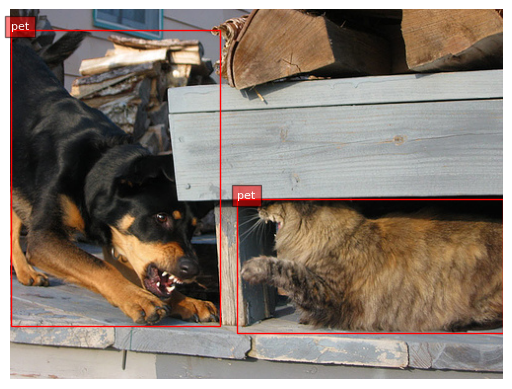

Visualizing filtered results for image: 1313987366.jpg


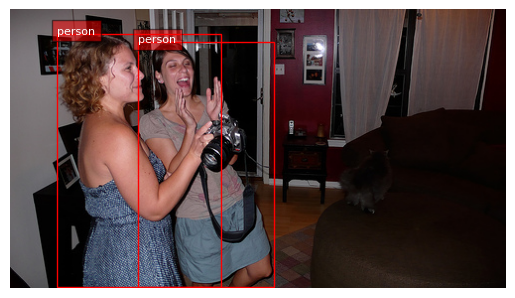

Visualizing filtered results for image: 1353009866.jpg


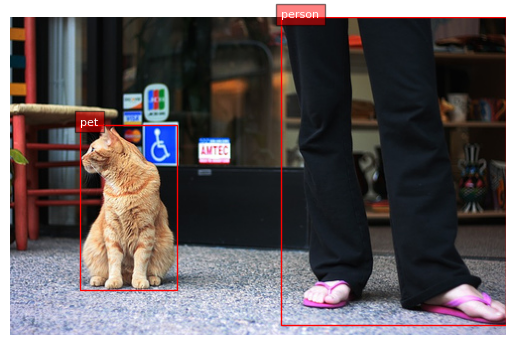

Visualizing filtered results for image: 143149186.jpg


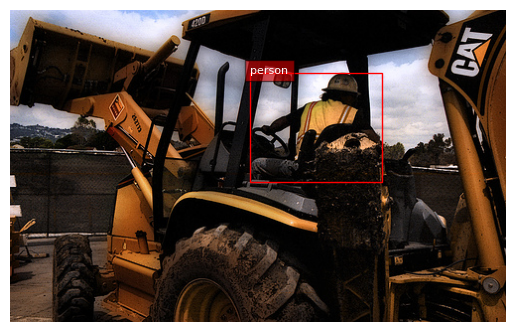

Visualizing filtered results for image: 1799271536.jpg


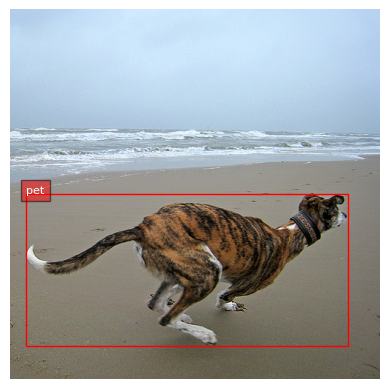

Visualizing filtered results for image: 1832085044.jpg


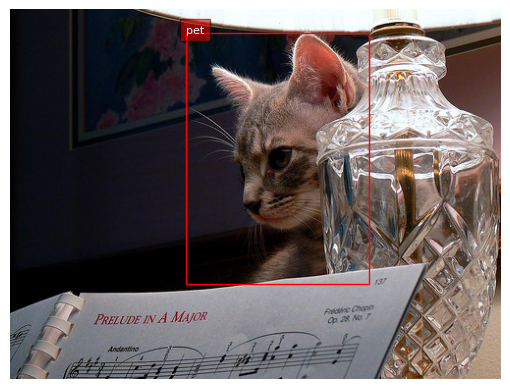

Visualizing filtered results for image: 189022647.jpg


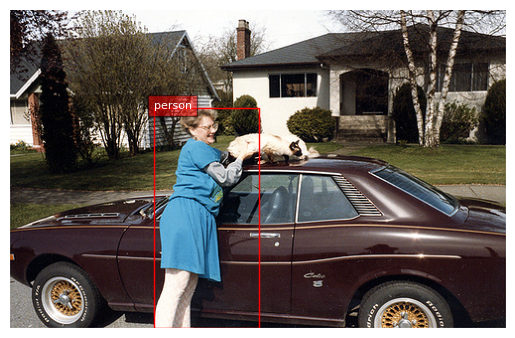

No relevant objects found in image: 2092480356.jpg
Visualizing filtered results for image: 2098646162.jpg


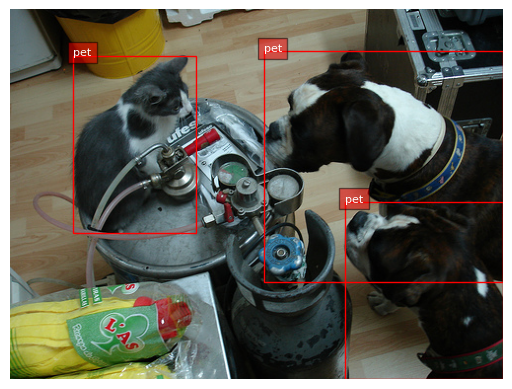

Visualizing filtered results for image: 2111061687.jpg


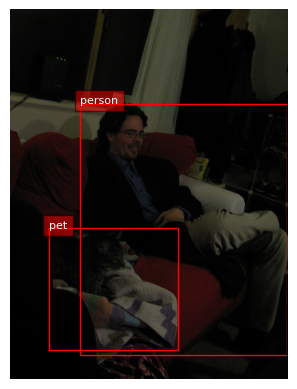

In [16]:
# Load filtered image names from CSV
images = pd.read_csv("labeled_images.csv")['image_name'].tolist()

# Select a subset of images for visualization
sample_images = images[:10]  # Adjust range as needed

print("Processing images using <OD> with filters...")

for img_name in sample_images:
    try:
        # Load the image
        image_path = f"flickr30k_images/{img_name}"  # Adjust to your dataset path
        image = Image.open(image_path).convert('RGB')
        
        # Step 1: Perform Object Detection
        task_prompt = '<OD>'
        od_results = run_example(task_prompt, image)
        
        # Extract bounding boxes and labels
        bboxes = od_results['<OD>']['bboxes']
        labels = od_results['<OD>']['labels']
        
        # Apply filters to refine results
        filtered_bboxes, filtered_labels = apply_filters(image, bboxes, labels)
        
        # Combine filtered results for visualization
        filtered_results = {'bboxes': filtered_bboxes, 'labels': filtered_labels}
        
        # Visualize the bounding boxes on the image
        if filtered_bboxes:
            print(f"Visualizing filtered results for image: {img_name}")
            plot_bbox(image, filtered_results)
        else:
            print(f"No relevant objects found in image: {img_name}")

    except Exception as e:
        print(f"Error processing image {img_name}: {e}")


In [17]:
# Load images with labels
images = pd.read_csv("labeled_images.csv")

# Separate images by their labels
cat_images = images[images['label'] == 'cat']['image_name'].tolist()
dog_images = images[images['label'] == 'dog']['image_name'].tolist()
person_images = images[images['label'] == 'person']['image_name'].tolist()

# Combine pet images (all cats + first 800 dogs)
selected_pet_images = cat_images + dog_images[:800]
selected_person_images = person_images[:750]  # First 750 person images

# Combine all selected images for processing
selected_images = selected_pet_images + selected_person_images

# Initialize counters and dictionaries
all_pet_detections = []
all_person_detections = []
dominant_image_labels = {}  # Maps each image to its assigned dominant label

print("Processing images using <OD> with filters...")

for img_name in tqdm(selected_images, desc="Filtering images", unit="image"):
    try:
        # Load the image
        image_path = f"flickr30k_images/{img_name}"  # Adjust to your dataset path
        image = Image.open(image_path).convert('RGB')
        
        # Step 1: Perform Object Detection
        task_prompt = '<OD>'
        od_results = run_example(task_prompt, image)
        
        # Extract bounding boxes and labels
        bboxes = od_results['<OD>']['bboxes']
        labels = od_results['<OD>']['labels']
        
        # Apply filters to refine results
        filtered_bboxes, filtered_labels = apply_filters(image, bboxes, labels)
        
        # Track all detections for counting
        for label in filtered_labels:
            if label == "pet":
                all_pet_detections.append(img_name)
            elif label == "person":
                all_person_detections.append(img_name)
        
        # Assign dominant label to each image
        if "pet" in filtered_labels:
            dominant_image_labels[img_name] = "pet"  # Pet has higher priority
        elif "person" in filtered_labels and img_name not in dominant_image_labels:
            dominant_image_labels[img_name] = "person"

    except Exception as e:
        print(f"Error processing image {img_name}: {e}")

# Save processed images with dominant labels to CSV
output_data = pd.DataFrame({
    'image_name': dominant_image_labels.keys(),
    'label': dominant_image_labels.values()
})
output_data.to_csv("final_labeled_images.csv", index=False)

# Print detailed counts
print(f"Total detected pet objects: {len(all_pet_detections)}")
print(f"Total detected person objects: {len(all_person_detections)}")
print(f"Number of images labeled as 'pet': {list(dominant_image_labels.values()).count('pet')}")
print(f"Number of images labeled as 'person': {list(dominant_image_labels.values()).count('person')}")
print(f"Saved processed image labels to 'final_labeled_images.csv'.")

Processing images using <OD> with filters...


Filtering images:   2%|▏         | 37/1624 [00:48<34:27,  1.30s/image]


KeyboardInterrupt: 